### TYK2 DMS/FlowDMS Global Rescaling

For BMS, we want to convert both the DMS and FlowDMS data to a 0-1 scale for interpretation individually, as well as for comparison on a "common" scale. For DMS, we use the normalized summary statistics from run 7, IFN-alpha 100 U/mL minus Untreated. For FlowDMS, we use the most recent midpoints computed from run 2. These formatted TSVs are located [here](../sumstats/BMS). We can make a simple plot of the relationship between the two derived scores across all variants:

In [2]:
library(ggpubr)
library(tidyverse)

In [25]:
midpoints <- read_tsv("/home/rstudio/bms-dms/sumstats/TYK2-VAMP/run2B/OCNT-VAMPLIB-1-assay-run2B-vampseq-midpoints.sumstats.tsv") %>%
    select(1:7) %>%
    mutate(mut_aa = if_else(mut_aa == "X", "*", mut_aa),
           chunk = as.numeric(gsub("rc", "", chunk)))

dms <- read_tsv("../sumstats/TYK2/run7/tyk2-assay7.tsv")  %>%
    mutate(aa = if_else(aa == "X", "*", aa),
           chunk = as.numeric(gsub("rc", "", chunk))) %>%
    filter(condition == "IFNalpha100_0 - None_0") %>%
    dplyr::select(chunk, pos, aa, estimate, std.error, statistic, p.value, p.adj) %>%
    mutate(fc = 2^estimate,
           fc_lci = 2^(estimate - 2*std.error),
           fc_uci = 2^(estimate + 2*std.error))

joined_unscaled <- inner_join(dms, midpoints, by = c("chunk", "pos", "aa" = "mut_aa")) %>%
    select(chunk, pos, aa, estimate, std.error, score_mean, score_se) %>%
    rename("DMS_Log2FoldChange" = "estimate",
           "DMS_Log2StdError" = "std.error",
           "FlowDMS_Midpoint" = "score_mean",
           "FlowDMS_StdError" = "score_se")

Rows: 23718 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): chunk, mut_aa
dbl (10): score_mean, score_se, pos, WT score, WT score standard error, esti...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 94876 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): drug, clone, chunk, aa, version, condition
dbl (8): conc, pos, estimate, std.error, dispersion, statistic, p.value, p.adj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
stop_scores <- midpoints %>%
    filter(mut_aa %in% c("X","*")) %>%
    group_by(chunk) %>%
    summarize("Stop score" = median(score_mean, na.rm = TRUE),
              "Stop score standard error" = median(score_se, na.rm = TRUE))

sample_stats_rescale <- midpoints %>%
    filter(mut_aa != "WT") %>%
    left_join(stop_scores, by = "chunk") %>%
    mutate(estimate = (score_mean - `Stop score`)/(`WT score` - `Stop score`),
           std.error = score_se/(`WT score` - `Stop score`))

flowdms_format <- sample_stats_rescale %>%
    select(chunk, pos, mut_aa, score_mean, score_se, estimate, std.error) %>%
    mutate("Midpoint_Lower" = score_mean - 2*score_se,
           "Midpoint_Upper" = score_mean - 2*score_se,
           "ScaledScore_Lower" = estimate - 2*std.error,
           "ScaledScore_Upper" = estimate + 2*std.error) %>%
    select(-std.error, -score_se) %>%
    rename("Chunk" = "chunk",
           "Position" = "pos",
           "AA" = "mut_aa",
           "Midpoint" = "score_mean",
           "ScaledScore" = "estimate") %>%
    relocate("ScaledScore", .after = "Midpoint_Upper") %>%
    arrange(Position, AA)

write_tsv(flowdms_format, "../sumstats/BMS/BMS-2/ExpressionDMS_midpoints_rescaled.tsv")

In [5]:
stop_scores_dms <- dms %>%
    filter(aa == "*") %>% 
    group_by(chunk) %>%
    summarize(stop_med = median(fc))

dms_rescale <- dms %>%
    left_join(stop_scores_dms, by = "chunk") %>%
    mutate(fc_rescale = (fc - stop_med)/(1 - stop_med),
           fc_lci_rescale = (fc_lci - stop_med)/(1 - stop_med),
           fc_uci_rescale = (fc_uci - stop_med)/(1 - stop_med))

dms_format <- dms_rescale %>%
    select(chunk, pos, aa, estimate, std.error, p.adj, fc_rescale, fc_lci_rescale, fc_uci_rescale) %>%
    rename("Chunk" = "chunk",
            "Position" = "pos",
            "AA" = "aa",
            "Log2FoldChange" = "estimate",
            "Log2FoldChangeError" = "std.error",
            "FDR" = "p.adj",
            "ScaledScore" = "fc_rescale",
            "ScaledScore_Lower" = "fc_lci_rescale",
            "ScaledScore_Upper" = "fc_uci_rescale") %>%
    arrange(Position, AA)


write_tsv(dms_format, "../sumstats/BMS/BMS-2/DMS_IFNalpha100vsUntreated_rescaled.tsv")

In [27]:
head(joined_unscaled)

chunk,pos,aa,DMS_Log2FoldChange,DMS_Log2StdError,FlowDMS_Midpoint,FlowDMS_StdError
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,21,*,-0.81433739,0.3063289,0.7560525,0.04781896
1,21,A,-0.19487115,0.2580405,0.6655018,0.04641744
1,21,C,-0.14394859,0.3543165,0.6584935,0.08690178
1,21,D,0.69739600,0.3478093,0.6451916,0.10136088
1,21,E,-0.06668819,0.3787260,0.6987993,0.04519290
1,21,F,-1.02415157,0.3011292,0.6457268,0.03683325


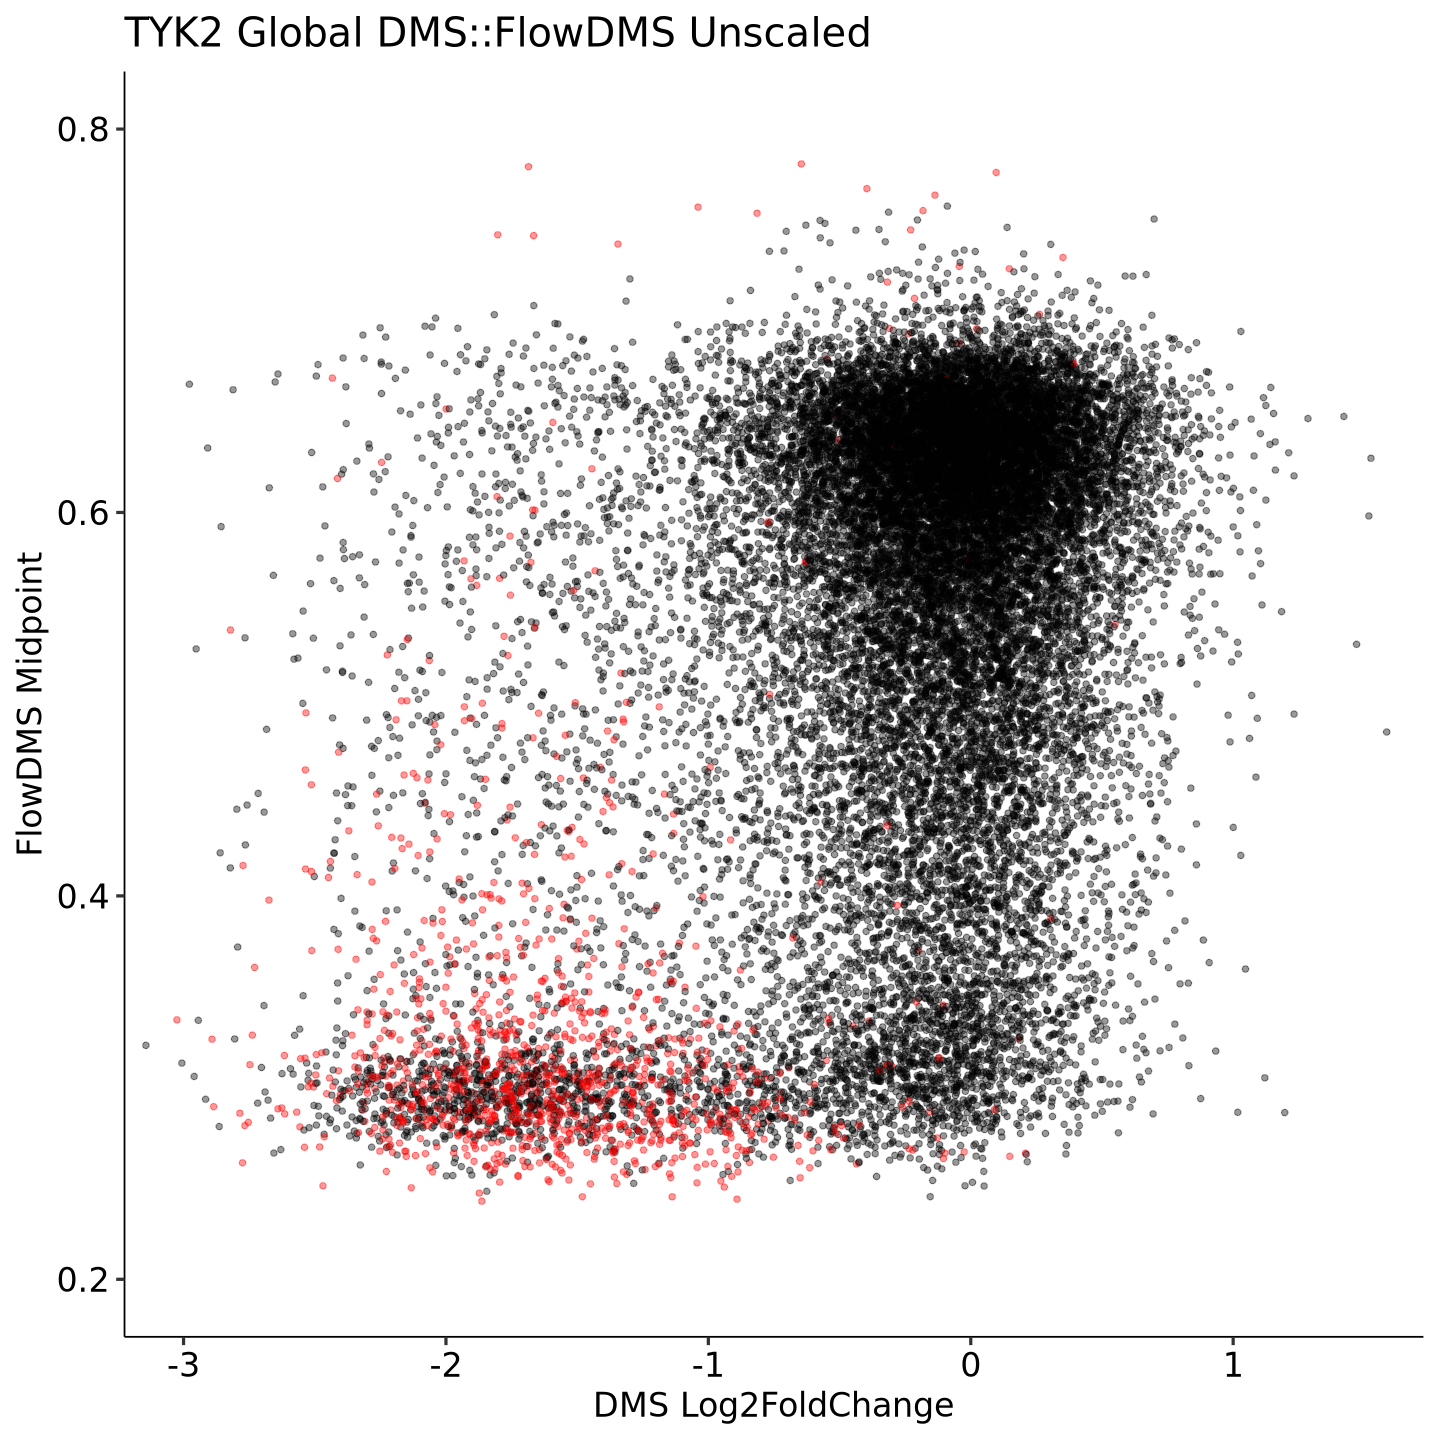

In [26]:
options(repr.plot.width = 12, repr.plot.height = 12)
ggplot(joined_unscaled) +
    geom_point(aes(x = DMS_Log2FoldChange,
                   y = FlowDMS_Midpoint,
                   color = if_else(aa == "*", "red", "black")),
               alpha = 0.4) +
    coord_cartesian(xlim = c(-3, 1.5),
                    ylim = c(0.2, 0.8)) +
    theme_pubr(base_size = 20) +
    xlab("DMS Log2FoldChange") +
    ylab("FlowDMS Midpoint") +
    scale_color_identity() +
    ggtitle("TYK2 Global DMS::FlowDMS Unscaled")

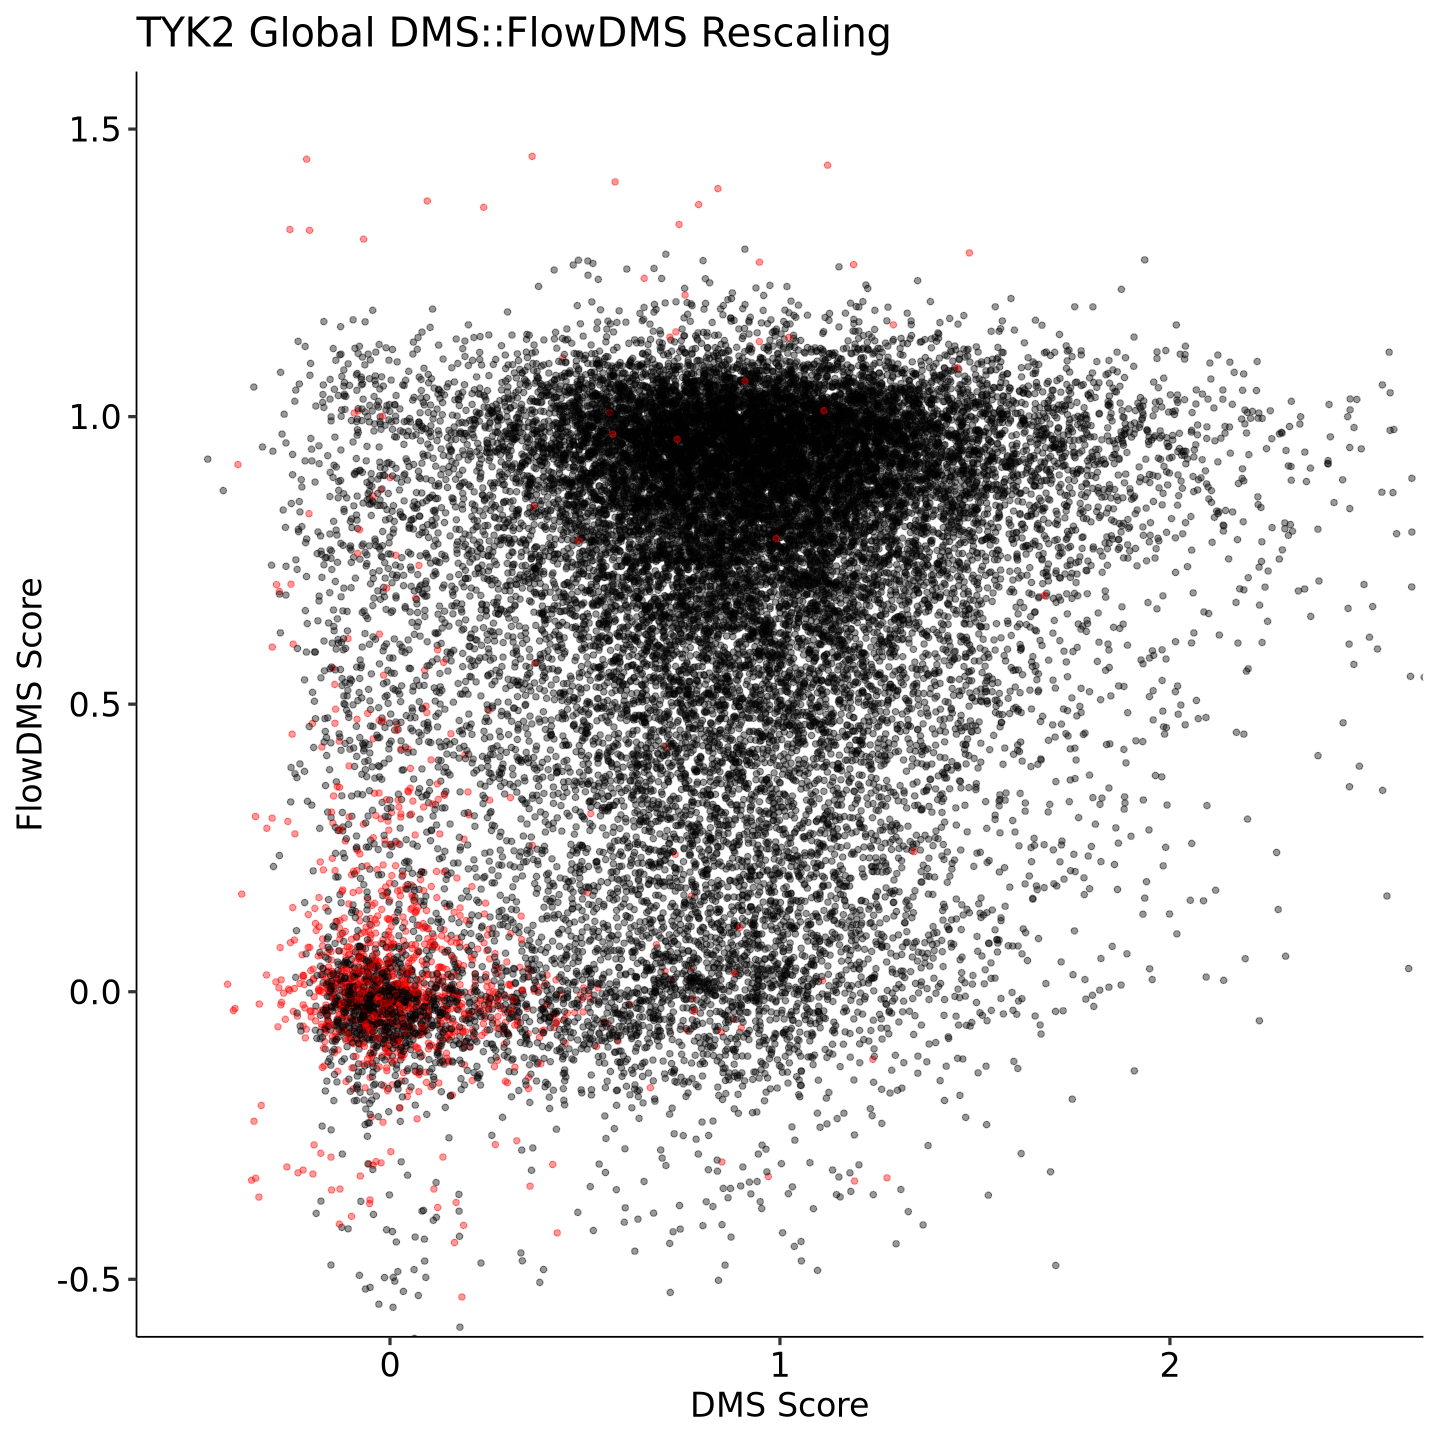

In [24]:
options(repr.plot.width = 12, repr.plot.height = 12)
inner_join(dms_format, flowdms_format, by = join_by(Chunk, Position, AA)) %>%
    ggplot() +
        geom_point(aes(x = ScaledScore.x,
                       y = ScaledScore.y,
                       color = if_else(AA == "*", "red", "black")),
                   alpha = 0.4) +
        coord_cartesian(xlim = c(-0.5, 2.5),
                        ylim = c(-0.5, 1.5)) +
        theme_pubr(base_size = 20) +
        xlab("DMS Score") +
        ylab("FlowDMS Score") +
        scale_color_identity() +
        ggtitle("TYK2 Global DMS::FlowDMS Rescaling")